https://github.com/bcgsc/AMPlify

In [1]:
import sys
sys.path.append('../')

In [2]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

/home/dmai/miniconda3/envs/bio-transformers/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [3]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.vocab import *
from mrl.callbacks import *
from mrl.callbacks.template_cb import *
from mrl.agent import *
from mrl.policy_gradient import *
from mrl.loss import *
from mrl.sampler import *
from mrl.environment import *
from mrl.reward import *

In [4]:
from biotransformers import BioTransformers

/home/dmai/miniconda3/envs/bio-transformers/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"
/home/dmai/miniconda3/envs/bio-transformers/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [5]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(1)
set_global_pool(cpus=8)

In [6]:
def ECFP6_pep(mol):
    mol = to_protein(mol)
    return ECFP6(mol)

## Bio-Transformer Stability Score

In [6]:
amp_df = pd.read_csv('../../smiles_datasets/amps/amp_clean.csv')

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [9]:
bio_trans = BioTransformers(backend="protbert", num_gpus=1)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
bio_trans._workers = None

In [12]:
bio_trans.finetune(
    amp_df.sequence.values,
    lr=1.0e-5,
    warmup_init_lr=1e-7,
    toks_per_batch=2000,
    epochs=10,
    batch_size=64,
    acc_batch_size=256,
    warmup_updates=1024,
    accelerator=None,
    checkpoint=None,
    save_last_checkpoint=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | BertForMaskedLM | 419 M 
1 | train_acc | Accuracy        | 0     
2 | val_acc   | Accuracy        | 0     
----------------------------------------------
419 M     Trainable params
0         Non-trainable params
419 M     Total params
1,679.733 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/dmai/miniconda3/envs/bio-transformers/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/home/dmai/miniconda3/envs/bio-transformers/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/dmai/miniconda3/envs/bio-transformers/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO: Model save at /home/dmai/mrl/dev_nbs/logs/finetune_masked/version_1/Rostlab_prot_bert_finetuned.pt.
INFO: Load model /home/dmai/mrl/dev_nbs/logs/finetune_masked/version_1/Rostlab_prot_bert_finetuned.pt
INFO: Training completed.


In [13]:
to_device(bio_trans._language_model._model);

In [32]:
class BioTransStability():
    def __init__(self, bio_trans, batch_size, shift=None, scale=None):
        self.bio_trans = bio_trans
        self.batch_size = batch_size
        self.shift = shift
        self.scale = scale
        
    def __call__(self, samples):
        loglikelihood = self.bio_trans.compute_loglikelihood(samples, 
                                                             batch_size=self.batch_size,
                                                               silent=True)
        loglikelihood = [loglikelihood[i]/len(samples[i]) for i in range(len(samples))]
        
        if self.shift is not None:
            loglikelihood = [i+self.shift for i in loglikelihood]
            
        if self.scale is not None:
            loglikelihood = [i*self.scale for i in loglikelihood]
            
        return loglikelihood

In [33]:
bio_reward = BioTransStability(bio_trans, 300, shift=5.)

In [35]:
bio_reward(amp_df.sequence.values[:10])

[2.2772428519588916,
 2.398370230843975,
 2.2474694323401967,
 2.040432614226561,
 1.9242334384835793,
 2.179052409711553,
 1.8084237730687103,
 2.0043384028138336,
 2.0696965973553034,
 2.276659580468973]

In [37]:
loglikelihood = bio_reward(amp_df.sequence.values[:1000])

In [38]:
vocab = CharacterVocab(AMINO_ACID_VOCAB)
rands = [''.join(np.random.choice(vocab.itos[4:], len(amp_df.sequence.values[i]))) for i in range(1000)]
loglikelihood2 = bio_reward(rands)

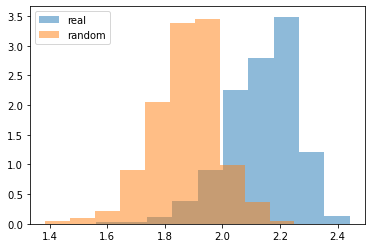

In [45]:
plt.hist(loglikelihood, density=True, alpha=0.5, label='real')
plt.hist(loglikelihood2, density=True, alpha=0.5, label='random')
plt.legend();

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [42]:
fpr, tpr, _ = roc_curve([1]*len(loglikelihood)+[0]*len(loglikelihood2), 
                        loglikelihood+loglikelihood2)

In [43]:
roc_auc = auc(fpr, tpr)

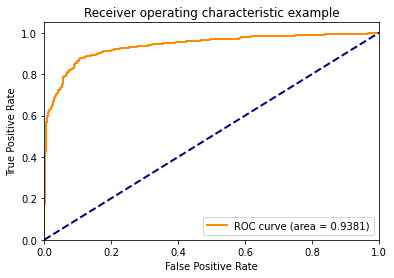

In [44]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Reward Function MLP

In [7]:
amp_df = pd.read_csv('../../smiles_datasets/amps/amp_clean.csv')

In [8]:
train_df = amp_df[amp_df.dataset=='train']
valid_df = amp_df[amp_df.dataset=='valid']

In [9]:
amp_ds = Vec_Prediction_Dataset(train_df.sequence.values, train_df.label.values, ECFP6_pep)
test_ds = Vec_Prediction_Dataset(valid_df.sequence.values, valid_df.label.values, ECFP6_pep)

In [10]:
amp_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.4, 0.4, 0.4, 0.4])

In [10]:
agent = PredictiveAgent(amp_model, BinaryCrossEntropy(), amp_ds, opt_kwargs={'lr':1e-3})

In [11]:
agent.train_supervised(32, 10, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,0.66279,0.25313,00:18
1,0.66020,0.14907,00:18
2,0.32865,0.18144,00:18
3,1.08829,0.13149,00:18
4,0.49333,0.09721,00:18
5,0.43109,0.23454,00:18
6,0.08713,0.17132,00:18
7,0.50496,0.06088,00:18
8,0.03624,0.16608,00:18
9,0.23914,0.09811,00:18


In [12]:
agent.train_supervised(32, 4, 1e-4)

Epoch,Train Loss,Valid Loss,Time
0,0.24908,0.16634,00:19
1,0.02654,0.14137,00:19
2,0.03109,0.13938,00:19
3,0.03010,0.11949,00:19


In [13]:
# validate

valid_dl = test_ds.dataloader(256, shuffle=False)
agent.model.eval();

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(valid_dl):
        batch = to_device(batch)
        x,y = batch
        pred = agent.model(x)
        preds.append(pred.detach().cpu())
        targs.append(y.detach().cpu())
        
preds = torch.cat(preds).numpy()
targs = torch.cat(targs).numpy()

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [15]:
fpr, tpr, _ = roc_curve(targs, torch.tensor(preds).sigmoid().squeeze().numpy())

In [16]:
roc_auc = auc(fpr, tpr)

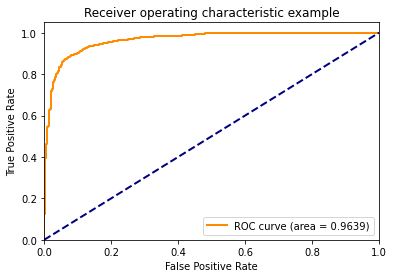

In [17]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
torch.save(agent.model.cpu().state_dict(), '../nbs/untracked_files/amp_mlp.pt')

## Reward Function LSTM

In [8]:
amp_df = pd.read_csv('../../smiles_datasets/amps/amp_clean.csv')

In [9]:
train_df = amp_df[amp_df.dataset=='train']
valid_df = amp_df[amp_df.dataset=='valid']

In [10]:
vocab = CharacterVocab(AMINO_ACID_VOCAB)

amp_ds = Text_Prediction_Dataset(train_df.sequence.values, train_df.label.values, vocab)
test_ds = Text_Prediction_Dataset(valid_df.sequence.values, valid_df.label.values, vocab)

In [11]:
class PoolingHead(nn.Module):
    def __init__(self, d_in, dims, d_out, drops, outrange=None):
        super().__init__()
        
        self.layers = MLP_Encoder(d_in, dims, d_out, drops)
        self.outrange = outrange
        
    def forward(self, x, mask=None):
        # x - bs, sl, d
        # mask - bs, sl
        if mask is not None:
            lengths = mask.sum(-1)
            final_vals = x[torch.arange(x.shape[0]), lengths-1]
            pool1 = x.masked_fill(mask.unsqueeze(-1), 0).sum(1)/lengths.unsqueeze(-1)
            pool2 = x.masked_fill(mask.unsqueeze(-1), -float('inf')).max(1)[0]
        else:
            final_vals = x[:,-1]
            pool1 = x.mean(1)
            pool2 = x.max(1)[0]
            
        x = torch.cat([final_vals, pool1, pool2], 1)
        x = self.layers(x)
        
        if self.outrange is not None:
            x = torch.sigmoid(x) * (self.outrange[1]-self.outrange[0]) + self.outrange[0]
        
        return x
    
class Predictive_LSTM(nn.Module):
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers, d_out_lstm,
                 head_dims, head_drops, d_out, pad_idx, outrange=None,
                 input_dropout=0., lstm_dropout=0., bidir=False,):
        super().__init__()
        
        self.embedding = nn.Embedding(d_vocab, d_embedding)
        
        self.lstm = LSTM(
                        d_embedding,
                        d_hidden,
                        d_out_lstm,
                        n_layers,
                        bidir=bidir,
                        input_dropout=input_dropout,
                        lstm_dropout=lstm_dropout,
                    )
        
        self.head = PoolingHead(d_out_lstm*3, head_dims, d_out, head_drops, outrange)
        self.pad_idx = pad_idx

        
    def forward(self, x, hiddens=None):
        
        mask = x==self.pad_idx
        x = self.embedding(x)
        encoded, hiddens = self.lstm(x, hiddens)
        output = self.head(encoded, mask)
        return output
    
    def freeze_encoder(self):
        for p in self.embedding.parameters():
            p.requires_grad_(False)
            
        for p in self.lstm.parameters():
            p.requires_grad_(False)
    
    def load_from_lm(self, lm_model):
        if hasattr(lm_model, 'block'):
            self.embedding.load_state_dict(lm_model.block.embedding.state_dict())
            self.lstm.load_state_dict(lm_model.block.lstm.state_dict())
        else:
            if hasattr(lm_model, 'lstm'):
                self.lstm.load_state_dict(lm_model.lstm.state_dict())
                
            if hasattr(lm_model, 'embedding'):
                self.embedding.load_state_dict(lm_model.embedding.state_dict())

In [12]:
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 2
head_dims = [256, 128]
head_drops = [0.3, 0.3]
d_out = 1
pad_idx = vocab.stoi['pad']
input_dropout=0.3
lstm_dropout=0.3

amp_model = Predictive_LSTM(d_vocab,
                            d_embedding,
                            d_hidden,
                            n_layers,
                            d_embedding,
                            head_dims,
                            head_drops,
                            d_out,
                            pad_idx,
                            input_dropout=input_dropout,
                            lstm_dropout=lstm_dropout)

In [13]:
agent = PredictiveAgent(amp_model, BinaryCrossEntropy(), amp_ds, opt_kwargs={'lr':1e-3})

In [26]:
agent.train_supervised(32, 12, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,0.79751,0.68119,00:03
1,0.46515,0.50006,00:03
2,0.33621,0.19746,00:03
3,0.34929,0.21048,00:03
4,0.14561,0.17964,00:03
5,0.61743,0.21720,00:03
6,0.19124,0.19954,00:03
7,0.32366,0.13282,00:03
8,0.07996,0.11885,00:03
9,0.10606,0.05646,00:03


In [27]:
# validate

valid_dl = test_ds.dataloader(256, shuffle=False)
agent.model.eval();

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(valid_dl):
        batch = to_device(batch)
        x,y = batch
        pred = agent.model(x)
        preds.append(pred.detach().cpu())
        targs.append(y.detach().cpu())
        
preds = torch.cat(preds).numpy()
targs = torch.cat(targs).numpy()

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [29]:
fpr, tpr, _ = roc_curve(targs, torch.tensor(preds).sigmoid().squeeze().numpy())

In [30]:
roc_auc = auc(fpr, tpr)

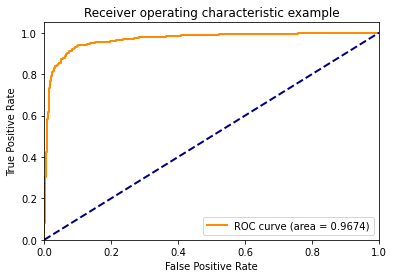

In [31]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [32]:
torch.save(agent.model.cpu().state_dict(), '../nbs/untracked_files/amp_pred_lstm.pt')

## Generative RL

In [7]:
bio_trans = BioTransformers(backend="protbert", num_gpus=1)

bio_trans.load_model("logs/finetune_masked/version_1/Rostlab_prot_bert_finetuned.pt")

class BioTransStability():
    def __init__(self, bio_trans, batch_size, shift=None, scale=None):
        self.bio_trans = bio_trans
        self.batch_size = batch_size
        self.shift = shift
        self.scale = scale
        
    def __call__(self, samples):
        loglikelihood = self.bio_trans.compute_loglikelihood(samples, 
                                                             batch_size=self.batch_size,
                                                               silent=True)
        loglikelihood = [loglikelihood[i]/len(samples[i]) for i in range(len(samples))]
        
        if self.shift is not None:
            loglikelihood = [i+self.shift for i in loglikelihood]
            
        if self.scale is not None:
            loglikelihood = [i*self.scale for i in loglikelihood]
            
        return loglikelihood

bio_reward_function = BioTransStability(bio_trans, 300, shift=5.)

bio_reward = FunctionReward(bio_reward_function, 
                            'bio', 
                            weight=1.)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO: Load model logs/finetune_masked/version_1/Rostlab_prot_bert_finetuned.pt


In [8]:
template = Template([ValidityFilter()], [], fail_score=-1., log=False, use_lookup=False, mode='protein')

In [9]:
template_cb = TemplateCallback(template, prefilter=True)

In [10]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [11]:
# vocab = CharacterVocab(AMINO_ACID_VOCAB)

# d_vocab = len(vocab.itos)
# d_embedding = 256
# d_hidden = 1024
# n_layers = 2
# head_dims = [256, 128]
# head_drops = [0.3, 0.3]
# d_out = 1
# pad_idx = vocab.stoi['pad']
# input_dropout=0.3
# lstm_dropout=0.3

# r_model = Predictive_LSTM(d_vocab,
#                             d_embedding,
#                             d_hidden,
#                             n_layers,
#                             d_embedding,
#                             head_dims,
#                             head_drops,
#                             d_out,
#                             pad_idx,
#                             input_dropout=input_dropout,
#                             lstm_dropout=lstm_dropout)


r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.4, 0.4, 0.4, 0.4])


# r_ds = Text_Prediction_Dataset(['M'], [0.], vocab)
r_ds = Vec_Prediction_Dataset(['M'], [0.], ECFP6_pep)

r_agent = PredictiveAgent(r_model, BinaryCrossEntropy(), r_ds, opt_kwargs={'lr':1e-3})

# r_agent.load_weights('../nbs/untracked_files/amp_pred_lstm.pt')
r_agent.load_weights('../nbs/untracked_files/amp_mlp.pt')

r_model.eval();

freeze(r_model)

class ClippedModelReward():
    def __init__(self, agent, minclip, maxclip):
        self.agent = agent
        self.minclip = minclip
        self.maxclip = maxclip
        
    def __call__(self, sequences):
        preds = self.agent.predict_data(sequences)
        preds = torch.clamp(preds, self.minclip, self.maxclip)
        return preds
        
reward_function = ClippedModelReward(r_agent, -5, 16)
        

amp_reward = FunctionReward(reward_function, 
                            'amp', 
                            weight=1.)

## LSTM LM

In [12]:
vocab = CharacterVocab(AMINO_ACID_VOCAB)

ds = Text_Dataset(['M'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_swissprot.pt'))

<All keys matched successfully>

In [13]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [14]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('rewards', 50, 97, 100)

samplers = [sampler1, sampler2, sampler3]

In [15]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [16]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[amp_reward, bio_reward], 
                  loss_cbs=[loss], cbs=cbs)

In [17]:
env.fit(200, 100, 2000, 10)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,amp,bio,PPO,rewards_live_p90,rewards_live_max
0,-0.915,0.000,1.000,1.000,200,1.000,1.000,-0.990,1.000,-2.974,2.059,1.005,2.417,6.410
10,-0.785,0.000,1.000,1.000,200,1.000,1.000,-0.483,1.000,-2.850,2.066,1.168,4.234,10.780
20,-0.522,0.000,1.000,1.000,200,1.000,1.000,-0.239,1.000,-2.594,2.071,1.426,5.440,9.985
30,-0.922,0.000,1.000,1.000,200,1.000,1.000,-0.798,1.000,-2.991,2.069,0.983,2.345,11.733
40,-0.622,0.000,1.000,1.000,200,1.000,1.000,-0.578,1.000,-2.700,2.078,1.023,2.694,12.086
50,-0.219,0.000,1.000,1.000,200,1.000,1.000,-0.153,1.000,-2.298,2.079,1.434,4.492,15.815
60,0.124,0.000,1.000,1.000,200,1.000,1.000,0.633,1.000,-1.947,2.071,1.428,6.252,12.422
70,-0.095,0.000,1.000,1.000,200,1.000,1.000,0.047,1.000,-2.172,2.077,1.121,5.247,10.395
80,0.352,0.000,1.000,1.000,200,1.000,1.000,0.641,1.000,-1.725,2.077,1.538,5.556,12.017
90,-0.168,0.000,1.000,1.000,200,1.000,1.000,0.329,1.000,-2.252,2.084,1.265,6.171,11.912


Epoch,Train Loss,Valid Loss,Time
0,2.58976,2.58053,00:00


Epoch,Train Loss,Valid Loss,Time
0,2.56499,2.58947,00:01


Epoch,Train Loss,Valid Loss,Time
0,2.56840,2.50695,00:02


Epoch,Train Loss,Valid Loss,Time
0,2.47416,2.44537,00:03


Epoch,Train Loss,Valid Loss,Time
0,2.48901,2.39329,00:03


Epoch,Train Loss,Valid Loss,Time
0,2.23170,2.30195,00:04


Epoch,Train Loss,Valid Loss,Time
0,2.31292,2.33738,00:05


Epoch,Train Loss,Valid Loss,Time
0,2.28423,2.38396,00:06


Epoch,Train Loss,Valid Loss,Time
0,2.25289,2.34133,00:06


Epoch,Train Loss,Valid Loss,Time
0,2.34090,2.24529,00:07


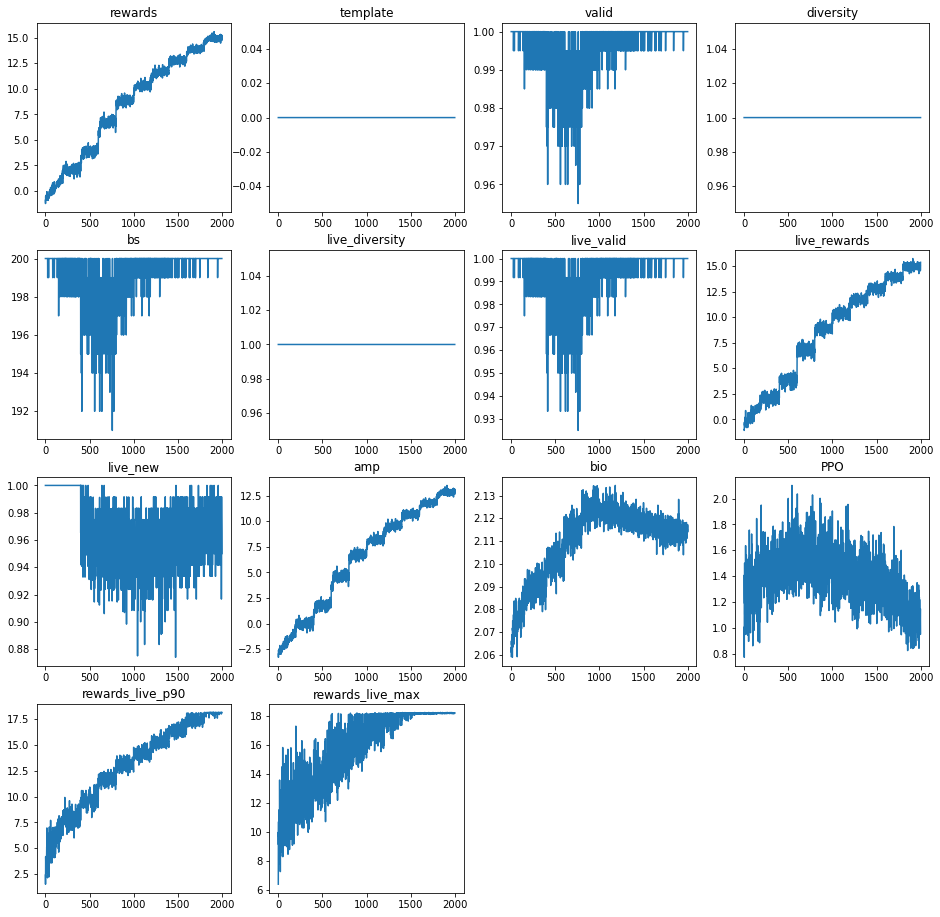

In [18]:
env.log.plot_metrics()

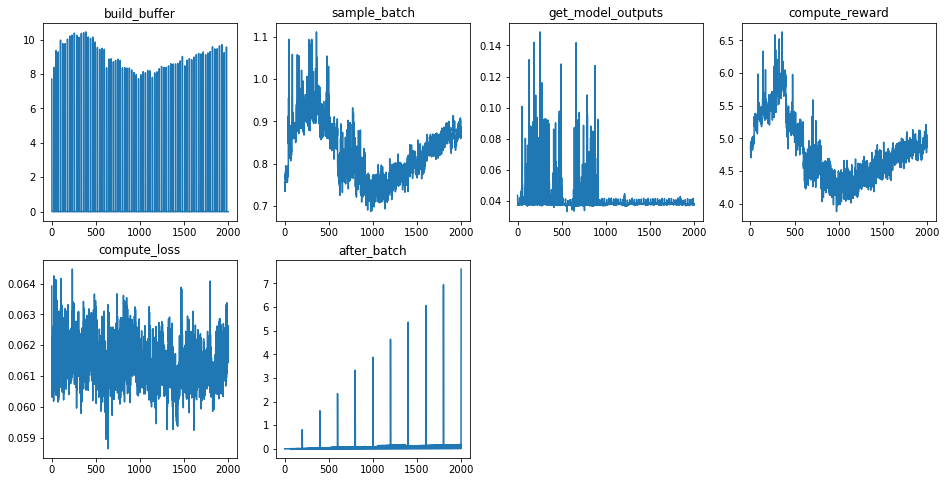

In [19]:
env.log.plot_timelog()

In [30]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)

In [31]:
log_df[log_df.rewards>18.22]

,samples,sources,rewards,template,amp,bio,PPO
46,GLIGFLGKKLGLALQLVLGGKKKAPAAAAGATSKGKKWRTLAASKG...,buffer,18.221981,0.0,16.0,2.221980,4.518168
145,GLFCIIGSKVLKKVALGKLGIVPVSKAWGGKVAKALYCGGYCKAGG...,live,18.223457,0.0,16.0,2.223458,2.991172
176,GLFSLIGKGGRGGSPNLAGGKGGGAGNAPGNPKPGKCSRNEAGHPP...,live,18.227434,0.0,16.0,2.227434,1.317216
167,GLASLSGGVGKVAAKVVVLLKLLQSPLGGLIAKLGNVASAPSPPPA...,live,18.223970,0.0,16.0,2.223971,1.238937
104,GIAGAVKKGGAAGLSLGILAPLGGLLAPGTPPPRPRPSPPGPKPGV...,live,18.228992,0.0,16.0,2.228992,0.786719
7,GLKGKGAAIAAAASKGAPAANIAGSIFGTIRAKLCFAMGTGPPGNA...,buffer,18.233147,0.0,16.0,2.233146,1.177154
171,GLGGGLLKAAKKILGGIKKSLNGTISGAAHGVAKGHPGTASKAIAK...,live,18.225279,0.0,16.0,2.225279,1.663422
42,GIPGGSSVGGVGNPKPPKARGAASIKAGGVSRSPSLPPGSAGSQLC...,buffer,18.228550,0.0,16.0,2.228550,1.071056
145,GLFCIIGKKVLKKVALGALGIVPVSKAWGGKVAKALYSGGYCAAGA...,live,18.223021,0.0,16.0,2.223021,0.833986
66,GLQAFGGVVGKGLKAVVPASGASKAPKPGTPALSRPVCRPASACVP...,buffer,18.227222,0.0,16.0,2.227223,1.142368


In [35]:
log_df[log_df.rewards>18.22].samples.values

array(['GLIGFLGKKLGLALQLVLGGKKKAPAAAAGATSKGKKWRTLAASKGSSGNVGGKGIGGGNGGMRGNPGSGNGAPGTLPKAGPSPPPAKPSKQTVATP',
       'GLFCIIGSKVLKKVALGKLGIVPVSKAWGGKVAKALYCGGYCKAGGKCKSLPANPKPKPICSCFSPLGDSGGKPTPKRASPVRSVNC',
       'GLFSLIGKGGRGGSPNLAGGKGGGAGNAPGNPKPGKCSRNEAGHPPGRPAHVALRLKSKFSAPIRGGA',
       'GLASLSGGVGKVAAKVVVLLKLLQSPLGGLIAKLGNVASAPSPPPASGPGSAAGGAPPRPRQLAGHPKAGAPPPPRGRPVQPRLH',
       'GIAGAVKKGGAAGLSLGILAPLGGLLAPGTPPPRPRPSPPGPKPGVASKAEAARPATGNPLPGVRFGVRCEAEFRGVVGKGGNPIPVPAGVCLT',
       'GLKGKGAAIAAAASKGAPAANIAGSIFGTIRAKLCFAMGTGPPGNATVKAVAAEPVNGAGAPGPGKGARAPSPNNSVAGPGAGGAPLGVHNPG',
       'GLGGGLLKAAKKILGGIKKSLNGTISGAAHGVAKGHPGTASKAIAKVSAKVCGKGFSVATAHLGHGFCCLRPRFIGPACGSPVKCNPRPADPIPAKRE',
       'GIPGGSSVGGVGNPKPPKARGAASIKAGGVSRSPSLPPGSAGSQLCKKGIIKLAGPARATLGKALLGAGNVGHFLSGKFRWC',
       'GLFCIIGKKVLKKVALGALGIVPVSKAWGGKVAKALYSGGYCAAGAKCASPPANPKPKPICSCFSPLGDSGGKPGNKRFSPGRSVNC',
       'GLQAFGGVVGKGLKAVVPASGASKAPKPGTPALSRPVCRPASACVPAGNAAARNIWKASIAALVAPGRGGHPSPLCLPSCGRVVLGAVT',
       'GS

In [37]:
log_df.reset_index(inplace=True, drop=True)

In [38]:
log_df

,samples,sources,rewards,template,amp,bio,PPO
0,MMMLNSMTRISTVRTAMTEATIHFPLITIVVPLLPSGILGLFIWDK...,buffer,-2.497042,0.0,-4.468587,1.971546,1.069331
1,MALYFEICFFLALTLSGLGEYKCPLPTSNNRYLLNTSFCPGSSIPW...,buffer,-2.155537,0.0,-4.189916,2.034379,0.796871
2,MNPGFIHTIEISNGQQCLHVLETEGKGGITIFRGREAKTVDEDVLA...,buffer,-0.356796,0.0,-2.451711,2.094915,-0.246076
3,MSSFAKKILLNGAATIALLLAFSILDSKTFVPQHCLSSAEICSSFS...,buffer,2.290118,0.0,0.168621,2.121497,0.730017
4,MKLILTLLSCITILAAFTSYVLSAAKLIESVRGQNQPVVQTCQPGN...,buffer,0.426683,0.0,-1.623839,2.050522,-0.329116
...,...,...,...,...,...,...,...
382189,GFGFGTLGSAGGYGYYVGPAITGQPPPYSPPSIASSSLKPYGGGGN...,live,16.922920,0.0,14.852718,2.070201,-0.073254
382190,GFGGGGGGFGRGGAPGGALRAVMGHGGGRPPRGGKGGIGAAKAQSP...,live,13.839074,0.0,11.671297,2.167777,1.663245
382191,GLGGAYRGVASALGPSPPPLPGNPVLGVIFKLKMSMHDCVSMGNWL...,live,17.149860,0.0,15.042373,2.107487,0.158110
382192,GTGGAFVKGALKLCKGYCGTILGTLALCIELAGHPGTGNCMKCERI...,live,16.708399,0.0,14.552161,2.156237,0.075795
